# STA9760 Project 2 - Yelp Data - Xuming Shi

In [1]:
%info


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1587950126517_0001,pyspark,idle,Link,Link,


In [2]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1587950126517_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1  
boto                       2.49.0 
jmespath                   0.9.4  
lxml                       4.4.2  
mysqlclient                1.4.6  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.14.5 
pip                        20.0.2 
py-dateutil                2.2    
python36-sagemaker-pyspark 1.2.6  
pytz                       2019.3 
PyYAML                     3.11   
setuptools                 46.1.3 
six                        1.13.0 
soupsieve                  1.9.5  
wheel                      0.34.2 
windmill                   1.6

# Install Libraries 

In [54]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Importing Essential Libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Read Business Data

In [7]:
df=spark.read.json('s3://sta-yelp/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Overview of Data

In [57]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

# First 5 Rows

In [59]:
df.createOrReplaceTempView('business')
sqldf = spark.sql(
'''
SELECT business_id,name,city,state,categories
FROM business
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+

## Analyzing Categories
We are going to create an association table by utilizing some PySpark transformations & Collection

## Some weired codes that I no longer consider...

In [22]:
df3=df.select("categories").rdd.flatMap(lambda x:str(x).split(', ')).collect()

def clean(dirty_str):
    clean_str=dirty_str.replace('Row(categories=\'','').replace(')','')
    return clean_str
   
cleaned_category=[clean(token) for token in df3]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Melt The DF

In [99]:
import pyspark.sql.functions as f

df.select(
"business_id",f.posexplode(f.split("categories", ", ")).alias("pos", "category")).drop('pos').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         business_id|            category|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|         Active Life|
|f9NumwFMBDn751xgF...|    Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|         Guns & Ammo|
|f9NumwFMBDn751xgF...|            Shopping|
|Yzvjg0SayhoZgCljU...|    Health & Medical|
|Yzvjg0SayhoZgCljU...|Fitness & Instruc...|
|Yzvjg0SayhoZgCljU...|                Yoga|
|Yzvjg0SayhoZgCljU...|         Active Life|
|Yzvjg0SayhoZgCljU...|             Pilates|
|XNoUzKckATkOD1hP6...|                Pets|
|XNoUzKckATkOD1hP6...|        Pet Services|
|XNoUzKckATkOD1hP6...|        Pet Groomers|
|6OAZjbxqM5ol29BuH...|     Hardware Stores|
|6OAZjbxqM5ol29BuH...|       Home Services|
|6OAZjbxqM5ol29BuH...|   Building Supplies|
|6OAZjbxqM5ol29BuH...|       Home & Garden|
|6OAZjbxqM5ol29BuH...|            Shopping|
|51M2Kk903DFYI6gnB...|       Home Services|
|51M2Kk903DFYI6gnB...|            Plumbing|
|51M2Kk903DFYI6gnB...|        El

## Group By Category

In [113]:
df.select(
"business_id",f.posexplode(f.split("categories", ", ")).alias("pos", "category"))\
.drop('pos')\
.select('category').groupby('category').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

## Convert to Pandas and Plot

In [126]:
df_pd=df.select(
"business_id",f.posexplode(f.split("categories", ", ")).alias("pos", "category"))\
.drop('pos')\
.select('category').groupby('category').count().toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

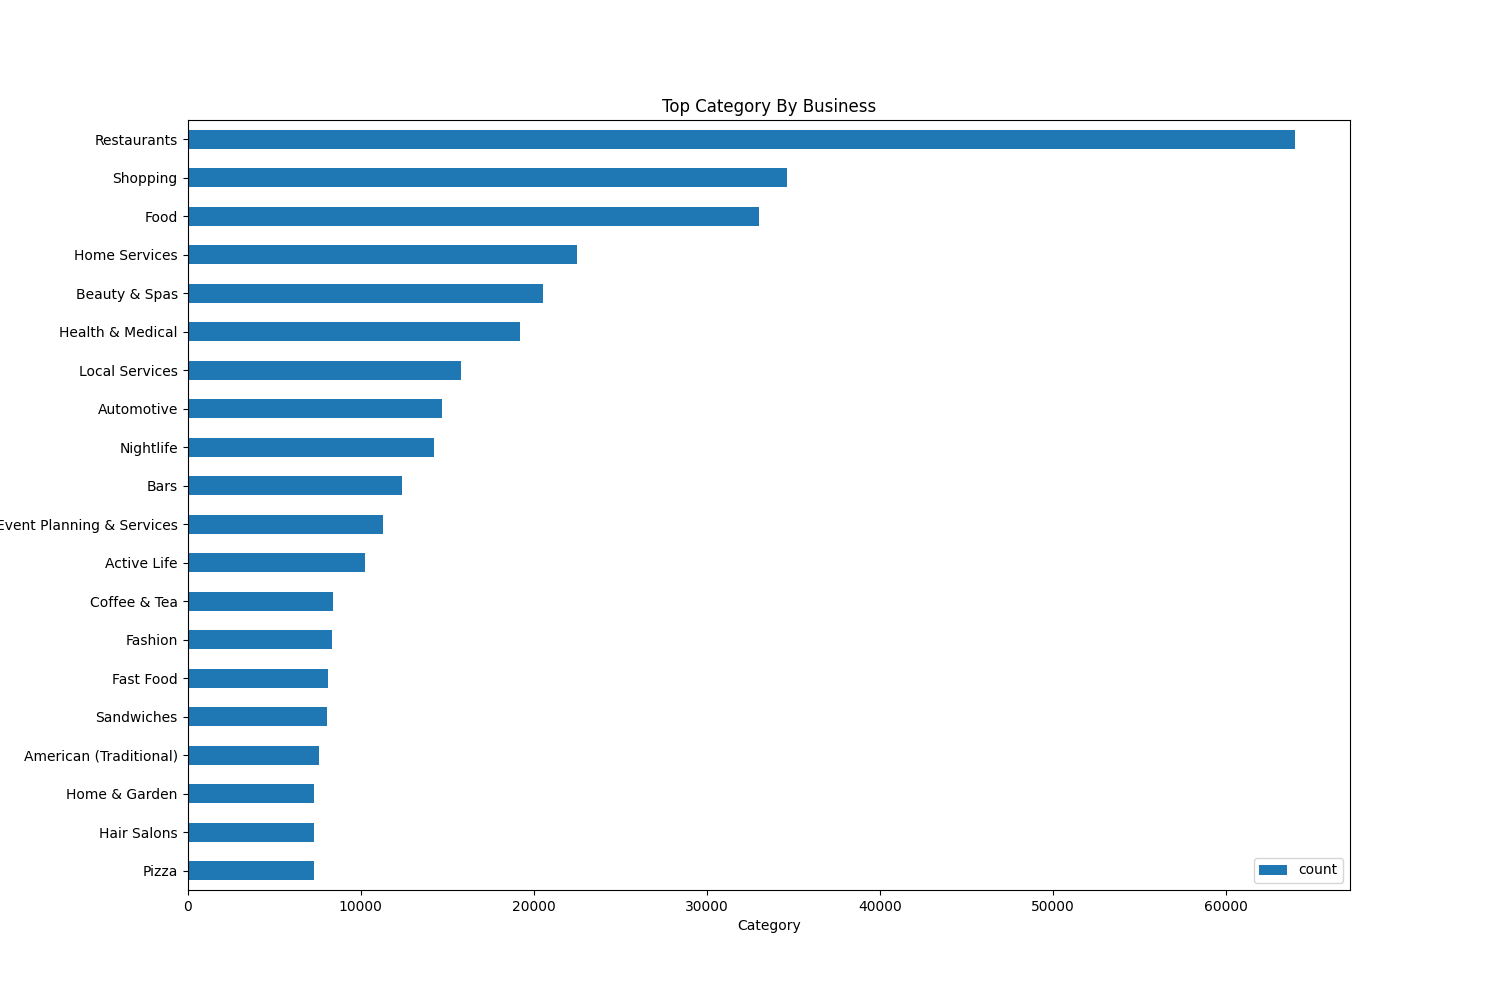

In [157]:
df_plt=df_pd.sort_values(by='count',ascending=False).head(20).sort_values(by='count',ascending=True)\
.plot(x='category',y='count',kind='barh',fontsize=10,figsize=(15, 10))
plt.ylabel('Count')
plt.xlabel('Category')
plt.title('Top Category By Business')
%matplot plt

## *Cheating Alert* : Semi-Pandas Approach

### 1. Create list for 'business_id' & 'category'

In [60]:
# Grap list of business_id & category in order to derive a 'flatten' table
bid=df.select("business_id").rdd.flatMap(lambda x: x).collect()

categories=df.select("categories").rdd.flatMap(lambda x: x).collect()

# my_dict={}
# for i in range(len(bid)):
#     my_dict[bid[i]]=categories[i]

# Contains a full list of categories
flat=[y for x in categories for y in str(x).split(', ')]

# Create new DF for plotting later on...
df2=pd.DataFrame(columns=['business_id','category'])

df2.category=flat

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2. Need to count how many categories a business_id contained

In [51]:
count=[len(str(token).split(', ')) for token in categories]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


### 3. business_id appear COUNT(category) times in this longer list

In [62]:
bid_long=[]
for index in range(len(count)):
    cnt=count[index]
    while cnt>0:
        bid_long.append(bid[index])
        cnt=cnt-1




VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4. Add the longer list to Dataframe

In [63]:
df2['business_id']=bid_long

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
print(df2.head())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

              business_id          category
0  f9NumwFMBDn751xgFiRbNA       Active Life
1  f9NumwFMBDn751xgFiRbNA  Gun/Rifle Ranges
2  f9NumwFMBDn751xgFiRbNA       Guns & Ammo
3  f9NumwFMBDn751xgFiRbNA          Shopping
4  Yzvjg0SayhoZgCljUJRF9Q  Health & Medical

### 5.Total Unique Categories

In [70]:
print(df2.groupby('category')['business_id'].count().sort_values(ascending=False))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

category
Restaurants                    63944
Shopping                       34644
Food                           32991
Home Services                  22487
Beauty & Spas                  20520
                               ...  
Tempura                            1
Sauna Installation & Repair        1
Island Pub                         1
Flyboarding                        1
Minho                              1
Name: business_id, Length: 1337, dtype: int64

### 6.Plot 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

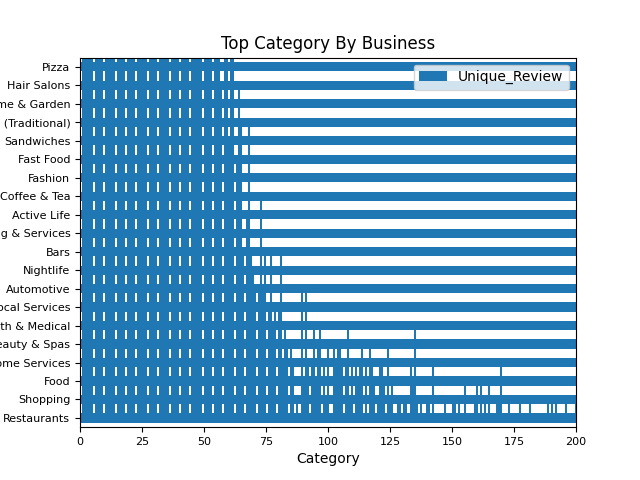

In [181]:
import matplotlib.pyplot as plt
group=df2.groupby('category')['business_id'].count().sort_values(ascending=False).head(20)
group.plot(kind='barh',fontsize=8)
plt.xlabel('Count')
plt.xlabel('Category')
plt.title('Top Category By Business')
%matplot plt

# Do Yelp Reviews Skew Negative?

### Load User Review Data 
And take a look at the schema

In [158]:
review=spark.read.json('s3://sta-yelp/yelp_academic_dataset_review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [159]:
print(review.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None

In [160]:
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT business_id,stars
FROM review
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+

In [161]:
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT business_id,AVG(stars)
FROM review
GROUP BY business_id
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vQGZjrDiDBuznOkUe...| 4.454545454545454|
|vyu1WGlnHGv2Z2MVE...|               5.0|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+

## Now Joining Review & Business Tables
Quiet a bit of efforts because of the Window Function...( and I hope it's the right approach because most of my brain cells are dead at this pt)

In [162]:
df.createOrReplaceTempView('business')
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT DISTINCT AVG(review.stars) OVER (PARTITION BY review.business_id) AS review_stars,business.stars,name,city,state
FROM 
business
JOIN
review
ON business.business_id=review.business_id
ORDER BY review_stars DESC
LIMIT 5
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+-----+--------------------+------------------+-----+
|review_stars|stars|                name|              city|state|
+------------+-----+--------------------+------------------+-----+
|         5.0|  5.0|Crossfit Culminat...|         Las Vegas|   NV|
|         5.0|  5.0|      The Auto Place|         Las Vegas|   NV|
|         5.0|  5.0|      Clayton Market|   North Las Vegas|   NV|
|         5.0|  5.0|   The Crooked Ćevap|Mentor-on-the-Lake|   OH|
|         5.0|  5.0|Jodine Wamsley, D...|        Scottsdale|   AZ|
+------------+-----+--------------------+------------------+-----+

## Compute The Skew

In [165]:
df.createOrReplaceTempView('business')
review.createOrReplaceTempView('review')
sqldf = spark.sql(
'''
SELECT ROUND((review_stars-stars)/stars,3) as skew FROM
(SELECT DISTINCT AVG(review.stars) OVER (PARTITION BY review.business_id) AS review_stars,business.stars,name,city,state
FROM 
business
JOIN
review
ON business.business_id=review.business_id

)
ORDER BY skew ASC

'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|  skew|
+------+
|-0.455|
|-0.397|
|-0.381|
|-0.377|
|-0.371|
| -0.37|
|-0.357|
| -0.35|
|-0.333|
|-0.323|
|-0.321|
| -0.32|
|-0.314|
|-0.314|
|-0.314|
|-0.314|
|-0.314|
|-0.314|
|-0.314|
|-0.313|
+------+
only showing top 20 rows

## Plot the Histogram for Skewness

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

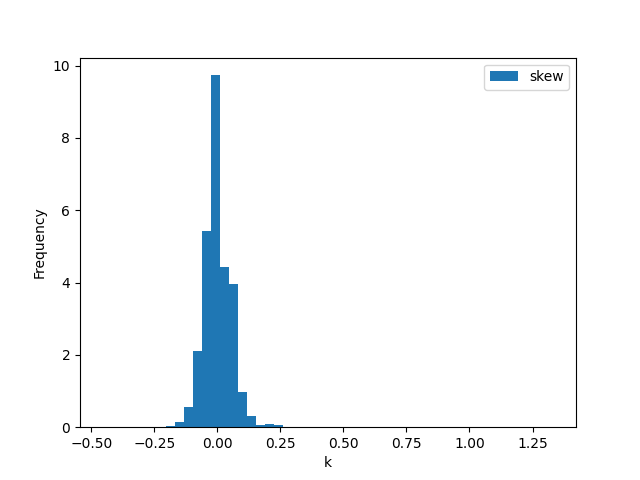

In [166]:
sqldf.toPandas().plot(kind='hist',bins=50,density=True)
plt.xlabel('k')
%matplot plt

# Should the Elite be Trusted? 
My Analysis Topic: Did 'Elite' users tried out more unique restaurants across different neighborhood vs. the normal users?

## Load User Data 
And take a look at the attributes

In [167]:
user=spark.read.json('s3://sta-yelp/yelp_academic_dataset_user.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [168]:
print(user.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

None

In [169]:
print(review.printSchema())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

None

## How Many Reviews Per State? (number seemed off, I need to double check)

In [171]:
review.createOrReplaceTempView('review')
df.createOrReplaceTempView('df')

sqldf = spark.sql(
'''
SELECT

df.state,

SUM((CASE WHEN YEAR(date) like '2015' THEN 1 ELSE 0 END)) AS review_15,
SUM((CASE WHEN YEAR(date) like '2016' THEN 1 ELSE 0 END)) AS review_16,
SUM((CASE WHEN YEAR(date) like '2017' THEN 1 ELSE 0 END)) AS review_17,
SUM((CASE WHEN YEAR(date) like '2018' THEN 1 ELSE 0 END)) AS review_18,
SUM((CASE WHEN YEAR(date) like '2019' THEN 1 ELSE 0 END)) AS review_19
FROM
review
JOIN
df
ON review.business_id=df.business_id
GROUP BY df.state

'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+---------+---------+---------+---------+---------+
|state|review_15|review_16|review_17|review_18|review_19|
+-----+---------+---------+---------+---------+---------+
|   AZ|   285043|   333201|   384267|   424433|   398919|
|   SC|     2905|     4214|     4946|     5770|     6384|
|   OR|        2|        1|        1|        3|        2|
|   VA|        6|        4|        4|        4|        5|
|   QC|    26198|    33157|    34184|    31022|    26126|
|   BC|        2|        1|        0|        2|        1|
|   MI|        0|        1|        4|       11|        8|
|   NV|   324219|   375426|   420030|   466689|   439240|
|   WI|    18988|    21156|    21556|    20737|    16634|
|   CA|       46|       54|       45|       53|       48|
|   NE|        0|        0|        5|        6|        9|
|   CT|        1|        0|        1|        4|        0|
|   NC|    55578|    69024|    79273|    91027|    90123|
|   VT|        0|        3|        2|        0|        1|
|   MO|       

## How Many Elite Users Per Year?

In [172]:
review.createOrReplaceTempView('review')
user.createOrReplaceTempView('user')

sqldf = spark.sql(
'''
SELECT

SUM((CASE WHEN elite like '%2015%' THEN 1 ELSE 0 END)) AS elite_15,
SUM((CASE WHEN elite like '%2016%' THEN 1 ELSE 0 END)) AS elite_16,
SUM((CASE WHEN elite like '%2017%' THEN 1 ELSE 0 END)) AS elite_17,
SUM((CASE WHEN elite like '%2018%' THEN 1 ELSE 0 END)) AS elite_18,
SUM((CASE WHEN elite like '%2019%' THEN 1 ELSE 0 END)) AS elite_19

FROM user
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+--------+--------+--------+
|elite_15|elite_16|elite_17|elite_18|elite_19|
+--------+--------+--------+--------+--------+
|   26409|   32128|   38645|   43026|       0|
+--------+--------+--------+--------+--------+

## How Many Elite Users On Yelp?

In [173]:
review.createOrReplaceTempView('review')
user.createOrReplaceTempView('user')
df.createOrReplaceTempView('bus')

sqldf = spark.sql(
'''
SELECT

COUNT(DISTINCT user_id) as Elite_Count

FROM user
WHERE elite NOT LIKE ''
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|Elite_Count|
+-----------+
|      75961|
+-----------+

## How Many Unique Postal Code Did The Elite Users Left Review For?

In [174]:
review.createOrReplaceTempView('review')
user.createOrReplaceTempView('user')
df.createOrReplaceTempView('bus')

elite_df = spark.sql(
'''
SELECT

COUNT (DISTINCT(bus.postal_code)) as Unique_Review
FROM user
JOIN review
ON user.user_id=review.user_id
JOIN
bus
ON
review.business_id=bus.business_id
WHERE elite NOT LIKE ''
GROUP BY user.user_id

'''
)

elite_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|Unique_Review|
+-------------+
|            1|
|            7|
|           15|
|           11|
|            3|
|            7|
|           28|
|            5|
|            2|
|            4|
|            2|
|            1|
|            2|
|            4|
|            4|
|            7|
|            3|
|            2|
|            5|
|            1|
+-------------+
only showing top 20 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

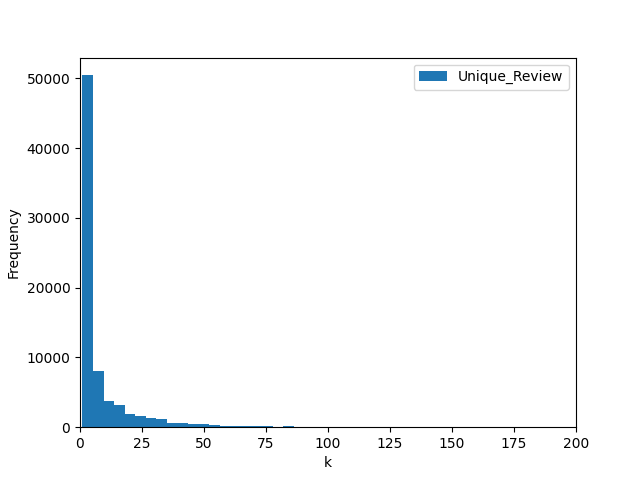

In [175]:
elite_df.toPandas().plot(kind='hist',bins=500)
plt.xlabel('k')
plt.xlim(left=0,right=200)
%matplot plt

## How Many Non-Elite Users On Yelp / Unique Count of Postal Codes / Plot..

In [178]:
review.createOrReplaceTempView('review')
user.createOrReplaceTempView('user')
df.createOrReplaceTempView('bus')

sqldf = spark.sql(
'''
SELECT

COUNT(DISTINCT user_id) as Elite_Count

FROM user
WHERE elite LIKE ''
'''
)

sqldf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|Elite_Count|
+-----------+
|    1892742|
+-----------+

## How Many Unique Postal Code Did The Non-Elite Users Left Review For?

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

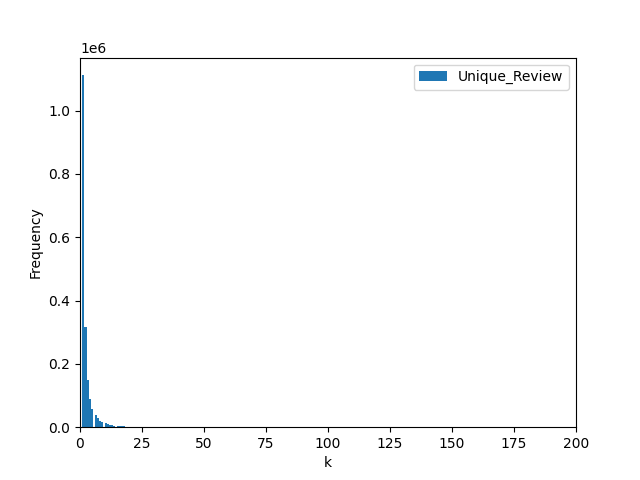

In [180]:
review.createOrReplaceTempView('review')
user.createOrReplaceTempView('user')
df.createOrReplaceTempView('bus')

elite_df = spark.sql(
'''
SELECT

COUNT (DISTINCT(bus.postal_code)) as Unique_Review
FROM user
JOIN review
ON user.user_id=review.user_id
JOIN
bus
ON
review.business_id=bus.business_id
WHERE elite LIKE ''
GROUP BY user.user_id

'''
)

elite_df.show()

elite_df.toPandas().plot(kind='hist',bins=500)
plt.xlabel('k')
plt.xlim(left=0,right=200)
%matplot plt


## Is There A Significant Difference? (will add if have time and $)